In [ ]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import networkx as nx
from semopy import semplot
from semopy import calc_stats
from IPython.display import Image

In [50]:
token_ids = {
    # Ongoing government shutdown
    "gov_shutdown_545": "7045107161367241233811523851106536676632348173555291268726302515224841822187",
    "gov_shutdown_763": "33863269898549252781275803678269200480782857182444175052616333799704258288948",
    "gov_shutdown_day": "63180324456084138896964901136480196139788004854700828798087417260562751585462",

    # Mixed macro picture
    "us_recession_2025": "104173557214744537570424345347209544585775842950109756851652855913015295701992",
    "fed_decisions_2025": "108483415714976290361271305280593264746125309611707698966906198707902268429606",
    "fed_decision_dec": "74018646712472971445258547247048869505144598783748525202442089895996249694683",

    # Sharp correction / AI sentiments
    "msft_price_nov25": "79366712640783192549004431572690423518507052197194852154324444873305516668498",
    "nvda_above_nov25": "20085731581751529026511534316101049820474111178674214083357775723904061557804",
    "nvda_above_nov14": "39581886549841090880905509315698538101325593642747204027615683331702494803428",
    "nvda_price_nov2025": "82867428501881085189484820117679815591951852048433338506125379110423550930197",

    # Global trade negotiations
    "trade_deals_2025": "5387225204087783518802178465274078547261862932574892838425263565124999003543",
    "trump_trade_before2027": "15956716365476211612502136275144529677999675468726683505087289708083638299709",
    "tariff_agreements_by_nov30": "21783243248036167372014169285747818472150510054656233937795397515654120166239"
}


In [51]:
def fetch_polymarket_prices(clob_token_id, interval="max"):
    url = f"https://clob.polymarket.com/prices-history?market={clob_token_id}&interval={interval}"
    r = requests.get(url, timeout=30)
    r.raise_for_status()
    j = r.json()
    data = j.get("history", [])
    if not data:
        return pd.DataFrame(columns=["date", "price"])
    df = pd.DataFrame(data)
    df["date"] = pd.to_datetime(df["t"], unit="s").dt.date
    df = df.groupby("date")["p"].mean().reset_index().rename(columns={"p": "price"})
    return df


In [52]:
dfs = {}
for name, tid in token_ids.items():
    df = fetch_polymarket_prices(tid, interval="max")
    dfs[name] = df.rename(columns={"price": name})
df_merged = None
for name, d in dfs.items():
    if df_merged is None:
        df_merged = d.copy()
    else:
        df_merged = pd.merge(df_merged, d, on="date", how="outer")
df_merged["date"] = pd.to_datetime(df_merged["date"], errors="coerce")
df_merged = df_merged.sort_values("date").reset_index(drop=True)
df_merged = df_merged.set_index("date")
numeric_cols = df_merged.select_dtypes(include=["number"]).columns
df_merged[numeric_cols] = df_merged[numeric_cols].interpolate(method="time").ffill().bfill()
df_merged = df_merged.reset_index()
print(df_merged.shape)
display(df_merged.head())


(32, 14)


,date,gov_shutdown_545,gov_shutdown_763,gov_shutdown_day,us_recession_2025,fed_decisions_2025,fed_decision_dec,msft_price_nov25,nvda_above_nov25,nvda_above_nov14,nvda_price_nov2025,trade_deals_2025,trump_trade_before2027,tariff_agreements_by_nov30
0,2025-10-11,0.060000,0.632692,0.069485,0.065000,0.705000,0.065000,0.5,0.4984,0.500625,0.5,0.085859,0.5325,0.5
1,2025-10-12,0.060660,0.632692,0.069485,0.061285,0.700451,0.065000,0.5,0.4984,0.500625,0.5,0.085983,0.5325,0.5
2,2025-10-13,0.061250,0.632692,0.069485,0.055000,0.695000,0.067118,0.5,0.4984,0.500625,0.5,0.085719,0.5325,0.5
3,2025-10-14,0.071979,0.632692,0.069485,0.055000,0.731007,0.061840,0.5,0.4984,0.500625,0.5,0.087056,0.5325,0.5
4,2025-10-15,0.080972,0.632692,0.069485,0.055000,0.781806,0.048819,0.5,0.4984,0.500625,0.5,0.091719,0.5325,0.5


In [ ]:
from sklearn.preprocessing import StandardScaler
observed_vars = list(dfs.keys())
print("Using observed vars:", observed_vars)

df_sem = df_merged.copy()
df_sem[observed_vars] = df_sem[observed_vars] * 100  

df_sem = df_sem.dropna(subset=observed_vars, how="all") 
df_sem[observed_vars] = df_sem[observed_vars].ffill().bfill()

constant_cols = [c for c in observed_vars if df_sem[c].nunique() <= 1]
if constant_cols:
    print("⚠️ Dropping constant columns:", constant_cols)
    df_sem = df_sem.drop(columns=constant_cols)
    observed_vars = [c for c in observed_vars if c not in constant_cols]

X = df_sem[observed_vars].astype(float)
scaler = StandardScaler()
X_std = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

print(X_std.shape)
display(X_std.head())


Using observed vars: ['gov_shutdown_545', 'gov_shutdown_763', 'gov_shutdown_day', 'us_recession_2025', 'fed_decisions_2025', 'fed_decision_dec', 'msft_price_nov25', 'nvda_above_nov25', 'nvda_above_nov14', 'nvda_price_nov2025', 'trade_deals_2025', 'trump_trade_before2027', 'tariff_agreements_by_nov30']
(32, 13)


,gov_shutdown_545,gov_shutdown_763,gov_shutdown_day,us_recession_2025,fed_decisions_2025,fed_decision_dec,msft_price_nov25,nvda_above_nov25,nvda_above_nov14,nvda_price_nov2025,trade_deals_2025,trump_trade_before2027,tariff_agreements_by_nov30
0,-0.666391,-1.652893,0.179605,2.136776,-0.919490,0.909402,0.751298,-0.567271,0.561659,0.750596,0.142985,0.44834,0.598436
1,-0.662962,-1.652893,0.179605,1.672800,-0.976821,0.909402,0.751298,-0.567271,0.561659,0.750596,0.146281,0.44834,0.598436
2,-0.659894,-1.652893,0.179605,0.887944,-1.045531,1.005513,0.751298,-0.567271,0.561659,0.750596,0.139247,0.44834,0.598436
3,-0.604133,-1.652893,0.179605,0.887944,-0.591696,0.766022,0.751298,-0.567271,0.561659,0.750596,0.174880,0.44834,0.598436
4,-0.557394,-1.652893,0.179605,0.887944,0.048575,0.175173,0.751298,-0.567271,0.561659,0.750596,0.299178,0.44834,0.598436


In [54]:
model_desc = """
us_recession_2025 ~~ fed_decisions_2025
gov_shutdown_545   ~ us_recession_2025 + fed_decisions_2025
gov_shutdown_763   ~ us_recession_2025 + fed_decisions_2025
gov_shutdown_day   ~ gov_shutdown_545 + gov_shutdown_763 + us_recession_2025
nvda_price_nov2025 ~ us_recession_2025 + fed_decisions_2025 + gov_shutdown_545 + gov_shutdown_day
nvda_above_nov25   ~ nvda_price_nov2025
nvda_above_nov14   ~ nvda_price_nov2025
msft_price_nov25   ~ nvda_price_nov2025 + us_recession_2025
trade_deals_2025   ~ gov_shutdown_545 + fed_decisions_2025
tariff_agreements_by_nov30 ~ trade_deals_2025
trump_trade_before2027 ~ trade_deals_2025 + tariff_agreements_by_nov30
gov_shutdown_545 ~~ gov_shutdown_763
trade_deals_2025 ~~ tariff_agreements_by_nov30
"""
print("Columns in X_std:", list(X_std.columns))

Columns in X_std: ['gov_shutdown_545', 'gov_shutdown_763', 'gov_shutdown_day', 'us_recession_2025', 'fed_decisions_2025', 'fed_decision_dec', 'msft_price_nov25', 'nvda_above_nov25', 'nvda_above_nov14', 'nvda_price_nov2025', 'trade_deals_2025', 'trump_trade_before2027', 'tariff_agreements_by_nov30']



Fit indices:


,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,45,68,377.637158,0.0,934.354119,0.616049,0.595831,0.389255,0.595831,0.419808,0.488313,42.397678,90.766962,11.801161



Path coefficients:
Index(['lval', 'op', 'rval', 'Estimate', 'Std. Err', 'z-value', 'p-value'], dtype='object')


,lval,op,rval,Estimate,p-value
0,gov_shutdown_545,~,us_recession_2025,-0.459207,4.349505e-03
1,gov_shutdown_545,~,fed_decisions_2025,-0.133568,4.068511e-01
2,gov_shutdown_763,~,us_recession_2025,-0.858892,8.881784e-15
3,gov_shutdown_763,~,fed_decisions_2025,0.212106,5.554746e-02
4,gov_shutdown_day,~,gov_shutdown_545,-0.879829,3.314898e-08
5,gov_shutdown_day,~,gov_shutdown_763,0.070227,7.513592e-01
6,gov_shutdown_day,~,us_recession_2025,-0.256139,1.758221e-01
7,nvda_price_nov2025,~,us_recession_2025,0.429461,1.951298e-05
8,nvda_price_nov2025,~,fed_decisions_2025,0.380537,7.228622e-06
9,nvda_price_nov2025,~,gov_shutdown_545,-0.421684,2.008105e-03


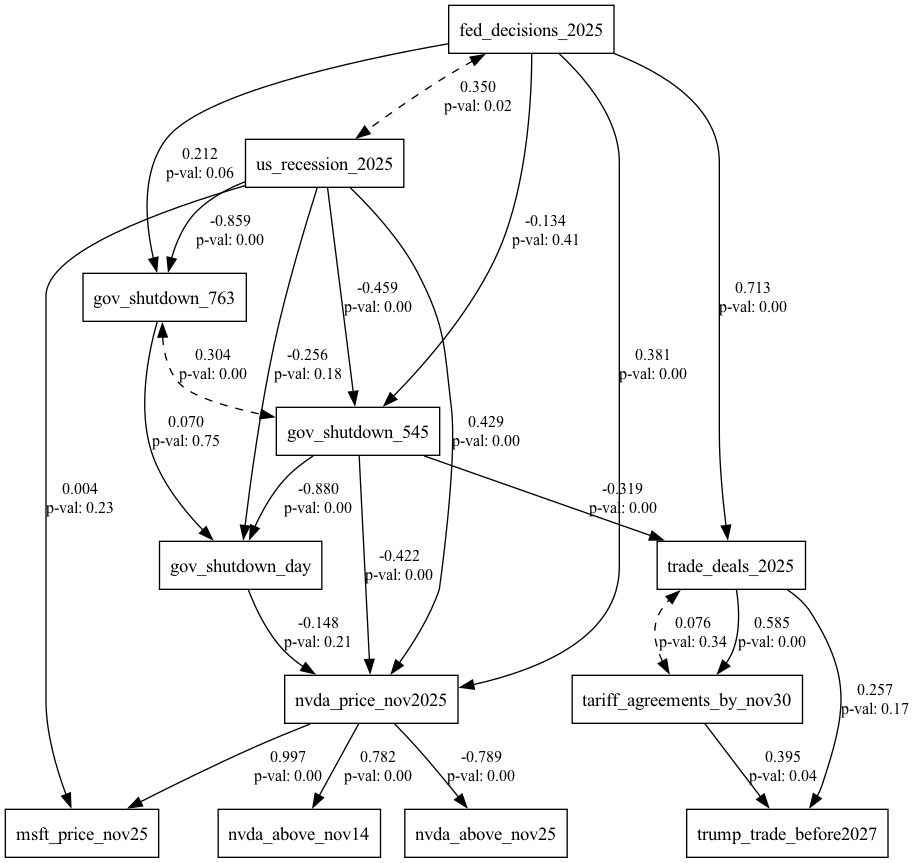


Interpretation tips:
- Coeff signs (positive/negative) indicate direction of the influence.
- Magnitude: standardized estimates (if you standardized) show relative strength.
- p-values and SE tell you if a path is statistically different from zero.
- Use modification indices (semopy can compute) to suggest missing paths, but treat with care.


In [ ]:


print("\nFit indices:")
stats = calc_stats(model)
display(stats)

print("\nPath coefficients:")
params = model.inspect()  
print(params.columns) 

cols_to_show = [c for c in ['lval', 'op', 'rval', 'Estimate', 'SE', 'p-value'] if c in params.columns]
display(params[cols_to_show])

semplot(model, "sem_model_graph.png", plot_covs=True)
from IPython.display import Image
display(Image(filename="sem_model_graph.png"))
print("\nInterpretation tips:")
print("- Coeff signs (positive/negative) indicate direction of the influence.")
print("- Magnitude: standardized estimates (if you standardized) show relative strength.")
print("- p-values and SE tell you if a path is statistically different from zero.")
print("- Use modification indices (semopy can compute) to suggest missing paths, but treat with care.")